Value at global minimum: 0.0
Gradient at global minimum: [0. 0.]


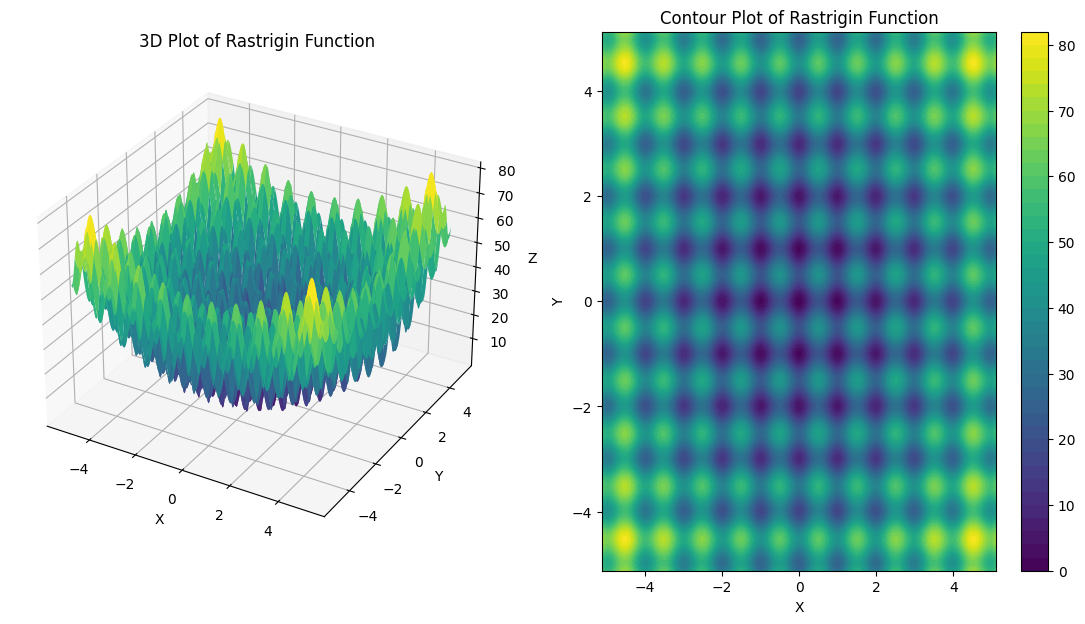

In [1]:
import numpy as np
import time
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

def rastrigin_function(x):
    A = 10
    return A*len(x) + sum([(xi**2 - A * np.cos(2 * np.pi * xi)) for xi in x])

def rastrigin_gradient(x):
    A = 10
    return np.array([2 * xi + 2 * np.pi * A * np.sin(2 * np.pi * xi) for xi in x])

x_global_min = [0, 0]
value_at_min = rastrigin_function(x_global_min)
gradient_at_min = rastrigin_gradient(x_global_min)

print("Value at global minimum:", value_at_min)
print("Gradient at global minimum:", gradient_at_min)

# Create a grid of points
X = np.linspace(-5.12, 5.12, 400)
Y = np.linspace(-5.12, 5.12, 400)
X, Y = np.meshgrid(X, Y)

# Compute the function values
Z = np.array([rastrigin_function([x, y]) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = Z.reshape(X.shape)

# Plotting
fig = plt.figure(figsize=(14, 7))

# 3D plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
ax1.set_title('3D Plot of Rastrigin Function')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

# 2D contour plot
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contourf(X, Y, Z, 50, cmap='viridis')
fig.colorbar(contour)
ax2.set_title('Contour Plot of Rastrigin Function')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')

plt.show()


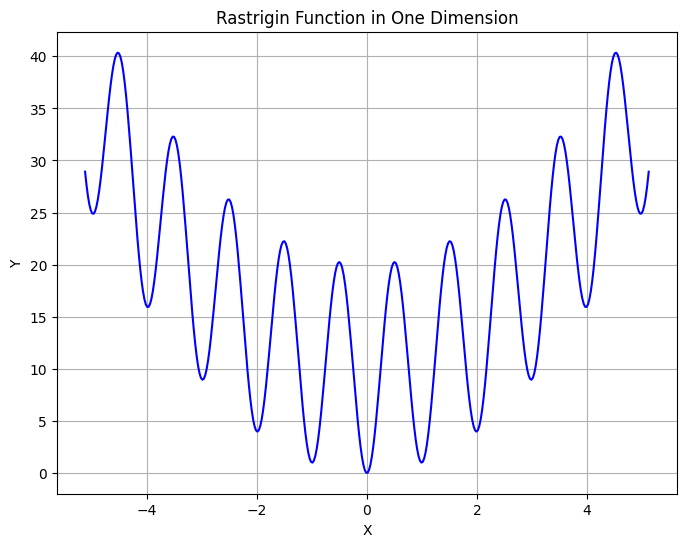

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Rastrigin function in one dimension
def rastrigin_function_1d(x):
    A = 10
    return A + (x**2 - A * np.cos(2 * np.pi * x))

# Create data points along the x-axis
x_values = np.linspace(-5.12, 5.12, 400)

# Compute the function values
y_values = rastrigin_function_1d(x_values)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, color='blue')
plt.title('Rastrigin Function in One Dimension')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()


In [2]:


# Redefine regular gradient descent with the complex test function
def gradient_descent_test(grad_f, init_theta, alpha, max_iter):
    theta = init_theta
    theta_updates = [theta.copy()]
    for i in range(max_iter):
        gradient = grad_f(theta)
        theta -= alpha * gradient
        theta_updates.append(theta.copy())
        if np.linalg.norm(alpha * gradient) < 1e-6:
            break
    return theta, theta_updates

# Simulated Annealing
def simulated_annealing_test(f, init_theta, T0, max_iter, cooling_rate):
    theta = init_theta
    theta_updates = [theta.copy()]
    T = T0
    for _ in range(max_iter):
        current_loss = f(theta)
        next_theta = theta + np.random.normal(0, 1, theta.shape) * T
        next_loss = f(next_theta)
        if next_loss < current_loss or np.exp((current_loss - next_loss) / T) > np.random.rand():
            theta = next_theta
        theta_updates.append(theta.copy())
        T *= cooling_rate
    return theta, theta_updates


def line_search(f, gradient, x, direction, alpha=0.9, beta=0.5, c=1e-2):
    while f(x + alpha * direction) > f(x) + c * alpha * np.dot(gradient, direction):
        alpha *= beta
        if alpha < 1e-4:
            break
    return alpha

def gdsa_momlinesearch(f, grad_f, init_theta, beta, T0, max_iter, epsilon=1e-4, delta_threshold=0.01):
    theta = init_theta
    theta_updates = [theta.copy()]
    v = np.zeros_like(theta)
    T = T0
    no_improvement_count =0
    previous_loss = f(theta)
    for i in range(max_iter):
        gradient = grad_f(theta)
        v = beta * v + gradient
        direction = -v
        alpha = line_search(f, gradient, theta, direction)
        theta_next = theta + alpha * direction
        current_loss = f(theta_next)
        delta_E = current_loss - previous_loss
        theta_change = np.linalg.norm(theta_next - theta)
        if abs(delta_E) > delta_threshold:
            theta = theta_next
            previous_loss = current_loss
        else:
            P_accept = np.exp(-delta_E / T)
            if np.random.rand() < P_accept:
                theta += beta * np.sign(np.random.rand(*theta.shape) - 0.5) * alpha * gradient
            T = max(T * 0.99, 0.001)
        theta_updates.append(theta.copy())
        no_improvement_count += 1
        if theta_change < epsilon and no_improvement_count > 10:
            break
    return theta, theta_updates

# need global convergence

# Additional refined version of GDSA to compare with the previous one

def gdsa__momentum(f, grad_f, init_theta, alpha, beta, T0, max_iter, epsilon=1e-4, delta_threshold=0.01):
    """
    Gradient Descent Simulated Annealing (GDSA) algorithm with momentum.
    Uses gradient descent initially and switches to simulated annealing when improvements slow down.
    """
    theta = init_theta
    v = np.zeros_like(theta)  # Initialize momentum vector
    theta_updates = [theta.copy()]
    T = T0  # Initial temperature
    previous_loss = f(theta)  # Initialize previous loss
    no_improvement_count = 0

    for i in range(max_iter):
        gradient = grad_f(theta)
        v = beta * v + gradient
        direction = -v
        theta_next = theta + alpha * direction
        theta_change = np.linalg.norm(theta_next - theta)

        current_loss = f(theta_next)
        delta_E = current_loss - previous_loss

        if abs(delta_E) > delta_threshold:
            theta = theta_next
            previous_loss = current_loss
            no_improvement_count = 0
        else:
            P_accept = np.exp(-delta_E / T)
            rand = np.random.rand()
            if rand < P_accept:
                theta +=  np.sign(np.random.rand(*theta.shape) - 0.5) * alpha * gradient
            T = max(T * 0.99, 0.001)  # Only cool down if using SA
        theta_updates.append(theta.copy())

        # Check for convergence
        if theta_change < epsilon:
            no_improvement_count += 1
            if no_improvement_count > 30:
                break
        else:
            no_improvement_count = 0

    return theta, theta_updates

# Run both algorithms for comparison



# Redefine regular GDSA for clarity
def gdsa_linesearch(f, grad_f, init_theta, alpha, beta, T0, max_iter, epsilon=1e-4, delta_threshold=0.1):
    """
    Gradient Descent Simulated Annealing (GDSA) algorithm with momentum.
    Uses gradient descent initially and switches to simulated annealing when improvements slow down.
    """
    theta = init_theta
    v = np.zeros_like(theta)  # Initialize momentum vector
    theta_updates = [theta.copy()]
    T = T0  # Initial temperature
    previous_loss = f(theta)  # Initialize previous loss
    no_improvement_count =0

    for i in range(max_iter):
        gradient = grad_f(theta)
        alpha = line_search(f, gradient, theta, -gradient)
        theta_next = theta - alpha * gradient
        theta_change = np.linalg.norm(theta_next - theta)

        current_loss = f(theta_next)
        delta_E = current_loss - previous_loss

        if abs(delta_E) > delta_threshold:
            theta = theta_next
            previous_loss = current_loss
        else:
            P_accept = np.exp(-delta_E / T)
            rand = np.random.rand()
            if rand < P_accept:
                theta +=  np.sign(np.random.rand(*theta.shape) - 0.5) * alpha * gradient
            # Since the default action is to accept theta_next, no else block needed
            T = max(T * 0.99, 0.001)  # Only cool down if using SA
        theta_updates.append(theta.copy())
        no_improvement_count += 1

        # Check for convergence
        if theta_change < epsilon and no_improvement_count > 30:
            break

    return theta, theta_updates


# New version of GDSA with enhanced perturbation and slower temperature decrease

def gdsa_linepertubation(f, grad_f, init_theta, beta, T0, max_iter, epsilon=1e-4, delta_threshold=0.01):
    """
    Further refined GDSA with adjusted convergence criteria, slower temperature decrease,
    and enhanced perturbation strategy to ensure better global search and prevent premature convergence.
    """
    theta = init_theta
    v = np.zeros_like(theta)
    theta_updates = [theta.copy()]
    T = T0
    previous_loss = f(theta)
    no_improvement_count = 0  # Counter to measure how many iterations without significant improvements

    for i in range(max_iter):
        gradient = grad_f(theta)
        alpha = line_search(f, gradient, theta, -gradient)
        theta_next = theta - alpha * gradient
        current_loss = f(theta_next)
        delta_E = current_loss - previous_loss
        theta_change = np.linalg.norm(theta_next - theta)

        if abs(delta_E) > delta_threshold:
            theta = theta_next
            previous_loss = current_loss
            no_improvement_count = 0  # Reset counter when improvement is significant
        else:
            P_accept = np.exp(-delta_E / T)
            rand = np.random.rand()
            if rand < P_accept:
                theta += np.random.normal(0, 1, size=theta.shape) * T  # Enhance perturbation based on temperature
            T = max(T * 0.99, 0.001)  # Slower cooling rate
            no_improvement_count += 1  # Increment counter for no significant improvement

        theta_updates.append(theta.copy())

        # Enhanced convergence criteria: stop if no improvement over 50 iterations
        if theta_change < epsilon and no_improvement_count > 30:
            break

    return theta, theta_updates


def gdsa(f, grad_f, init_theta, alpha, beta, T0, max_iter, epsilon=1e-4, delta_threshold=0.1):
    """
    Gradient Descent Simulated Annealing (GDSA) algorithm without momentum.
    Uses simple gradient descent initially and switches to simulated annealing when improvements slow down.
    """
    theta = init_theta
    theta_updates = [theta.copy()]
    T = T0  # Initial temperature
    previous_loss = f(theta)  # Initialize previous loss
    no_improvement_count = 0

    for i in range(max_iter):
        gradient = grad_f(theta)
        theta_next = theta - alpha * gradient
        theta_change = np.linalg.norm(theta_next - theta)

        current_loss = f(theta_next)
        delta_E = current_loss - previous_loss

        if abs(delta_E) > delta_threshold:
            theta = theta_next
            previous_loss = current_loss
            no_improvement_count = 0
        else:
            P_accept = np.exp(-delta_E / T)
            rand = np.random.rand()
            if rand < P_accept:
                theta += np.sign(np.random.rand(*theta.shape) - 0.5) * alpha * gradient
            T = max(T * 0.99, 0.001)
        theta_updates.append(theta.copy())

        # Check for convergence
        if theta_change < epsilon and no_improvement_count > 10:
            break

    return theta, theta_updates









In [80]:
import numpy as np

def line_search2(f, gradient, x, alpha=0.9, beta=0.5, c=1e-2):
    f_x = f(x)
    while f(x - alpha * gradient) > f_x + c * alpha * np.dot(-gradient, gradient):
        alpha *= beta
        if alpha < 1e-4:
            break
    return alpha


def gdsa_linesearch2(f, grad_f, init_theta, alpha, beta, T0, max_iter, epsilon=1e-4, delta_threshold=0.1):
    """
    Gradient Descent Simulated Annealing (GDSA) algorithm with momentum.
    Uses gradient descent initially and switches to simulated annealing when improvements slow down.
    """
    theta = init_theta

    theta_updates = [theta.copy()]
    T = T0  # Initial temperature
    previous_loss = f(theta)  # Initialize previous loss
    no_improvement_count =0

    for i in range(max_iter):
        gradient = grad_f(theta)
        alpha = line_search2(f, gradient, theta)
        theta_next = theta - alpha * gradient
        theta_change = np.linalg.norm(theta_next - theta)

        current_loss = f(theta_next)
        delta_E = current_loss - previous_loss
        # print('delta_E',delta_E)

        if abs(delta_E) > delta_threshold:
            theta = theta_next
            previous_loss = current_loss
            # print('update',theta)
        else:
            P_accept = np.exp(-abs(delta_E) / T)
            rand = np.random.rand()
            if rand < P_accept:
                theta += np.sign(np.random.rand(*theta.shape) - 0.5) * alpha * gradient
                # print('else update',theta)
            # Since the default action is to accept theta_next, no else block needed

            T = max(T * 0.99, 0.001)  # Only cool down if using SA
        theta_updates.append(theta.copy())
        no_improvement_count += 1

        # Check for convergence
        if theta_change < epsilon and no_improvement_count > 20:
            break

    return theta, theta_updates


In [77]:
# def line_search2_improved(f, gradient, x, alpha=1.0, beta=0.5, c=1e-4):
#     """Improved backtracking line search with reduced function calls."""
#     f_x = f(x)
#     f_trial = 0
#     while f_trial > f_x + c * alpha * np.dot(gradient, -gradient):
#         alpha *= beta
#         if alpha < 1e-8:
#             break
#         x = x - alpha * gradient
#         f_trial = f(x)
#     return alpha, f_trial,x

# def gdsa_linesearch2_improved(f, grad_f, init_theta, alpha, beta, T0, max_iter, epsilon=1e-4, delta_threshold=0.1):
#     """GDSA with improved line search."""
#     theta = init_theta
#     theta_updates = [theta.copy()]
#     T = T0
#     previous_loss = f(theta)
#     no_improvement_count = 0

#     for i in range(max_iter):
#         gradient = grad_f(theta)
#         alpha,current_loss,theta_next = line_search2_improved(f, gradient, theta)
#         theta_change = np.linalg.norm(theta_next - theta)

#         delta_E = current_loss - previous_loss

#         if abs(delta_E) > delta_threshold:
#             theta = theta_next
#             print('update')
#             previous_loss = current_loss
#         else:
#             P_accept = np.exp(-delta_E / T)
#             rand = np.random.rand()
#             if rand < P_accept:
#                 theta += np.sign(np.random.rand(*theta.shape) - 0.5) * alpha * gradient
#                 print('else',theta)
#             T = max(T * 0.99, 0.001)
#         theta_updates.append(theta.copy())
#         no_improvement_count += 1

#         if theta_change < epsilon and no_improvement_count > 30:
#             break

#     return theta, theta_updates



In [81]:


# Testing the functions
init_theta = np.random.uniform(-5.12, 5.12, 2)
alpha = 0.01
beta = 0.9
T0 = 20
max_iter = 1000

start_time = time.time()
theta_gd, updates_gd = gradient_descent_test(rastrigin_gradient, init_theta.copy(), alpha, max_iter)
time_gd = time.time() - start_time

start_time = time.time()
theta_sa, updates_sa = simulated_annealing_test(rastrigin_function, init_theta.copy(), T0, max_iter, 0.99)
time_sa = time.time() - start_time

start_time = time.time()
theta_momlinesearch, updates_momlinesearch = gdsa_momlinesearch(rastrigin_function, rastrigin_gradient, init_theta.copy(), beta, T0, max_iter)
time_momlinesearch = time.time() - start_time

start_time_gdsa = time.time()
theta_momentum, updates_momentum = gdsa__momentum(rastrigin_function, rastrigin_gradient, init_theta.copy(), alpha, beta, T0, max_iter)
time_momentum = time.time() - start_time_gdsa

start_time_gdsa = time.time()
theta_linesearch, updates_linesearch = gdsa_linesearch2(rastrigin_function, rastrigin_gradient, init_theta.copy(), alpha, beta, T0, max_iter)
time_linesearch = time.time() - start_time_gdsa


start_time_gdsa = time.time()
theta_gdsa, updates_gdsa = gdsa(rastrigin_function, rastrigin_gradient, init_theta.copy(), alpha, beta, T0, max_iter)
time_gdsa = time.time() - start_time_gdsa

start_time_linepertubation = time.time()
theta_linepertubation, updates_linepertubation = gdsa_linepertubation(rastrigin_function, rastrigin_gradient, init_theta.copy(), alpha, beta, T0, max_iter)
time_linepertubation = time.time() - start_time_linepertubation




print("Gradient Descent Result:", theta_gd, "Time:", time_gd)
print("Simulated Annealing Result:", theta_sa, "Time:", time_sa)
print("GDSA with momlinesearch:", theta_momlinesearch, "Time:", time_momlinesearch)
print("GDSA_gdsa theta_momentum:", theta_momentum, "Time:", time_momentum)
print("GDSA_gdsa theta_linesearch:", theta_linesearch, "Time:", time_linesearch)
print("GDSA_gdsa:", theta_gdsa, "Time:", time_gdsa)
print("GDSA_gdsa time_linepertubation:", theta_linepertubation, "Time:", time_linepertubation)



Gradient Descent Result: [-0.58329709 -0.90532684] Time: 0.016350269317626953
Simulated Annealing Result: [9.94805854e-01 8.82252063e-04] Time: 0.020965099334716797
GDSA with momlinesearch: [-5.12844828e-07 -9.20840132e-05] Time: 0.18658804893493652
GDSA_gdsa theta_momentum: [ 7.86538316 -1.07454347] Time: 0.02053046226501465
GDSA_gdsa theta_linesearch: [1.29035680e-04 9.06474848e-07] Time: 0.011708974838256836
GDSA_gdsa: [ 0.32186211 -0.90532684] Time: 0.018535375595092773
GDSA_gdsa time_linepertubation: [ 4.96744858 -2.99479699] Time: 0.0031654834747314453


In [5]:
update_gd = np.vstack(updates_gd)
update_sa = np.vstack(updates_sa)
updates_momlinesearch = np.vstack(updates_momlinesearch)
updates_momentum = np.vstack(updates_momentum)
updates_linesearch = np.vstack(updates_linesearch)
updates_linepertubation = np.vstack(updates_linepertubation)
updates_gdsa = np.vstack(updates_gdsa)

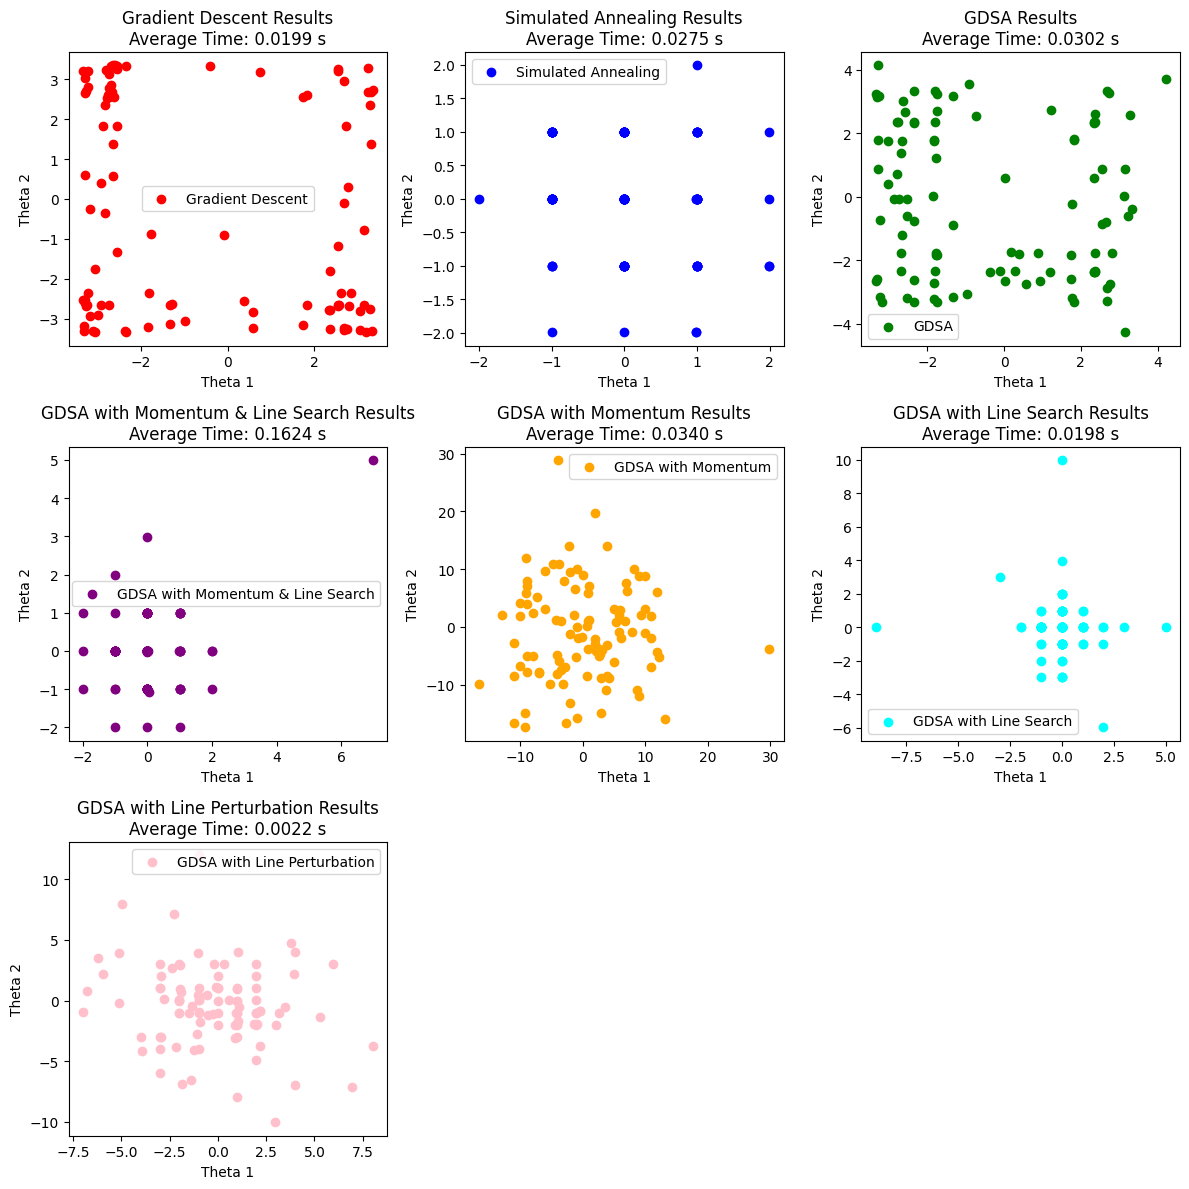

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Simulation parameters
alpha = 0.01
beta = 0.9
T0 = 10
max_iter = 1000
num_trials = 100

# Results containers
final_theta_gd = np.zeros((num_trials, 2))
final_theta_sa = np.zeros((num_trials, 2))
final_theta_gdsa = np.zeros((num_trials, 2))
final_theta_momlinesearch = np.zeros((num_trials, 2))
final_theta_momentum = np.zeros((num_trials, 2))
final_theta_linesearch = np.zeros((num_trials, 2))
final_theta_linepertubation = np.zeros((num_trials, 2))

times_gd = []
times_sa = []
times_gdsa = []
times_momlinesearch = []
times_momentum = []
times_linesearch = []
times_linepertubation = []

# Run simulations
for i in range(num_trials):
    init_theta = np.random.uniform(-10, 10, 2)

    start_time = time.time()
    final_theta_gd[i], updates_gd = gradient_descent_test(rastrigin_gradient, init_theta.copy(), alpha, max_iter)
    times_gd.append(time.time() - start_time)

    start_time = time.time()
    final_theta_sa[i], updates_sa = simulated_annealing_test(rastrigin_function, init_theta.copy(), T0, max_iter, 0.99)
    times_sa.append(time.time() - start_time)

    start_time = time.time()
    final_theta_gdsa[i], updates_gdsa = gdsa(rastrigin_function, rastrigin_gradient, init_theta.copy(), alpha, beta, T0, max_iter)
    times_gdsa.append(time.time() - start_time)

    start_time = time.time()
    final_theta_momlinesearch[i], updates_momlinesearch = gdsa_momlinesearch(rastrigin_function, rastrigin_gradient, init_theta.copy(), beta, T0, max_iter)
    times_momlinesearch.append(time.time() - start_time)

    start_time = time.time()
    final_theta_momentum[i], updates_momentum = gdsa__momentum(rastrigin_function, rastrigin_gradient, init_theta.copy(), alpha, beta, T0, max_iter)
    times_momentum.append(time.time() - start_time)

    start_time = time.time()
    final_theta_linesearch[i], updates_linesearch = gdsa_linesearch2(rastrigin_function, rastrigin_gradient, init_theta.copy(), alpha, beta, T0, max_iter)
    times_linesearch.append(time.time() - start_time)

    start_time = time.time()
    final_theta_linepertubation[i], updates_linepertubation = gdsa_linepertubation(rastrigin_function, rastrigin_gradient, init_theta.copy(), alpha, beta, T0, max_iter)
    times_linepertubation.append(time.time() - start_time)

# Calculate average times
avg_time_gd = np.mean(times_gd)
avg_time_sa = np.mean(times_sa)
avg_time_gdsa = np.mean(times_gdsa)
avg_time_momlinesearch = np.mean(times_momlinesearch)
avg_time_momentum = np.mean(times_momentum)
avg_time_linesearch = np.mean(times_linesearch)
avg_time_linepertubation = np.mean(times_linepertubation)

# Plotting
plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.scatter(final_theta_gd[:, 0], final_theta_gd[:, 1], color='red', label='Gradient Descent')
plt.title(f'Gradient Descent Results\nAverage Time: {avg_time_gd:.4f} s')
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')
plt.legend()

plt.subplot(3, 3, 2)
plt.scatter(final_theta_sa[:, 0], final_theta_sa[:, 1], color='blue', label='Simulated Annealing')
plt.title(f'Simulated Annealing Results\nAverage Time: {avg_time_sa:.4f} s')
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')
plt.legend()

plt.subplot(3, 3, 3)
plt.scatter(final_theta_gdsa[:, 0], final_theta_gdsa[:, 1], color='green', label='GDSA')
plt.title(f'GDSA Results\nAverage Time: {avg_time_gdsa:.4f} s')
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')
plt.legend()

plt.subplot(3, 3, 4)
plt.scatter(final_theta_momlinesearch[:, 0], final_theta_momlinesearch[:, 1], color='purple', label='GDSA with Momentum & Line Search')
plt.title(f'GDSA with Momentum & Line Search Results\nAverage Time: {avg_time_momlinesearch:.4f} s')
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')
plt.legend()

plt.subplot(3, 3, 5)
plt.scatter(final_theta_momentum[:, 0], final_theta_momentum[:, 1], color='orange', label='GDSA with Momentum')
plt.title(f'GDSA with Momentum Results\nAverage Time: {avg_time_momentum:.4f} s')
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')
plt.legend()

plt.subplot(3, 3, 6)
plt.scatter(final_theta_linesearch[:, 0], final_theta_linesearch[:, 1], color='cyan', label='GDSA with Line Search')
plt.title(f'GDSA with Line Search Results\nAverage Time: {avg_time_linesearch:.4f} s')
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')
plt.legend()

plt.subplot(3, 3, 7)
plt.scatter(final_theta_linepertubation[:, 0], final_theta_linepertubation[:, 1], color='pink', label='GDSA with Line Perturbation')
plt.title(f'GDSA with Line Perturbation Results\nAverage Time: {avg_time_linepertubation:.4f} s')
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')
plt.legend()

plt.tight_layout()
plt.show()


Gradient:

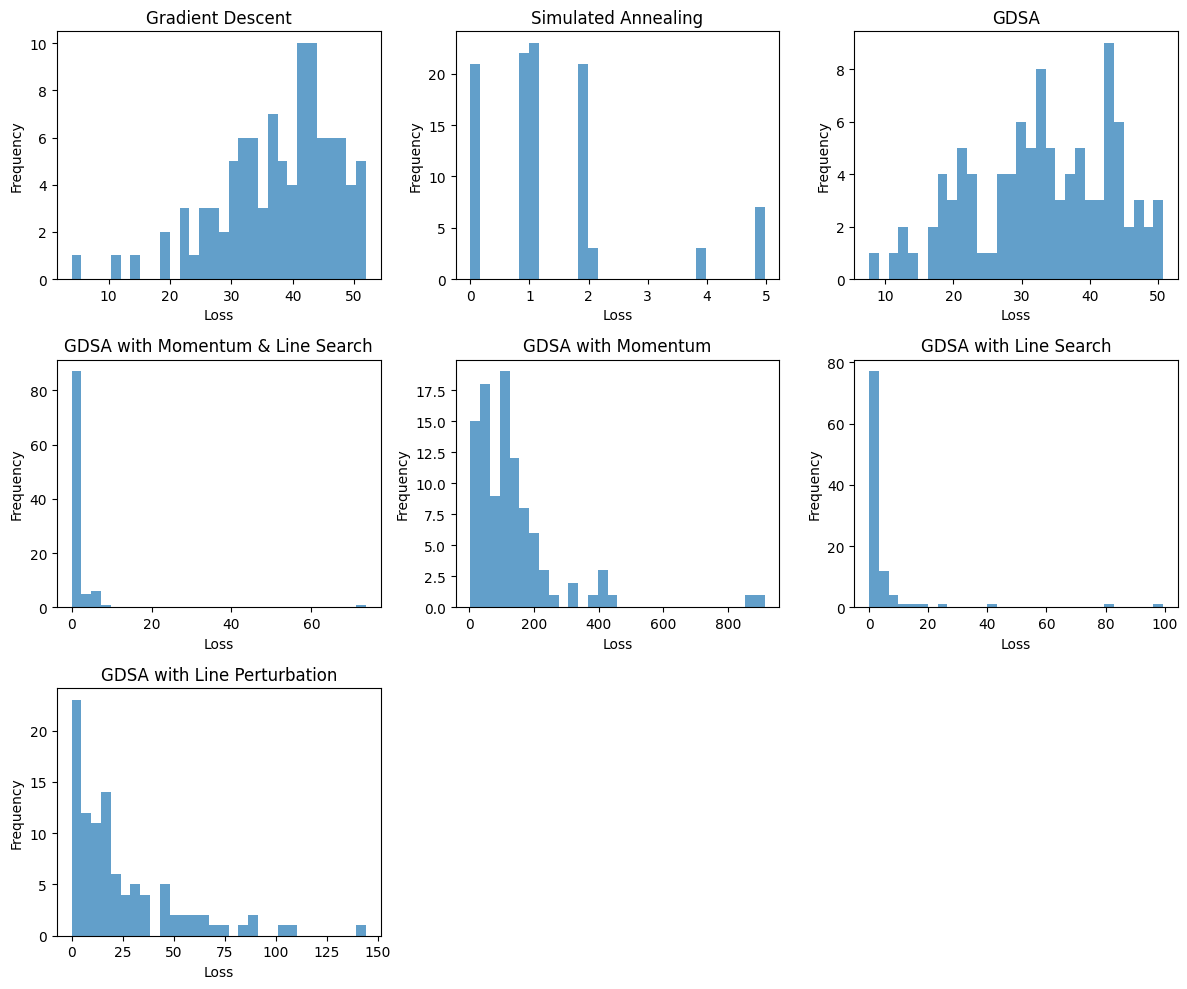

In [83]:


# calculate loss
loss_gd = np.array([rastrigin_function(theta) for theta in final_theta_gd])
loss_sa = np.array([rastrigin_function(theta) for theta in final_theta_sa])
loss_gdsa = np.array([rastrigin_function(theta) for theta in final_theta_gdsa])
loss_momlinesearch = np.array([rastrigin_function(theta) for theta in final_theta_momlinesearch])
loss_momentum = np.array([rastrigin_function(theta) for theta in final_theta_momentum])
loss_linesearch = np.array([rastrigin_function(theta) for theta in final_theta_linesearch])
loss_linepertubation = np.array([rastrigin_function(theta) for theta in final_theta_linepertubation])

# plot
plt.figure(figsize=(12, 10))
titles = ['Gradient Descent', 'Simulated Annealing', 'GDSA', 'GDSA with Momentum & Line Search', 'GDSA with Momentum', 'GDSA with Line Search', 'GDSA with Line Perturbation']
losses = [loss_gd, loss_sa, loss_gdsa, loss_momlinesearch, loss_momentum, loss_linesearch, loss_linepertubation]

for i, (loss, title) in enumerate(zip(losses, titles), 1):
    plt.subplot(3, 3, i)
    plt.hist(loss, bins=30, alpha=0.7)
    plt.title(title)
    plt.xlabel('Loss')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [84]:
average_loss_gd = np.mean(loss_gd)
average_loss_sa = np.mean(loss_sa)
average_loss_gdsa_linesearch = np.mean(loss_linesearch)

print("The average loss for gradient descent is:", average_loss_gd)
print("The average loss for simulated annealing is:", average_loss_sa)
print("The average loss for GDSA linesearch is:", average_loss_gdsa_linesearch)

The average loss for gradient descent is: 37.756140399140456
The average loss for simulated annealing is: 1.3934619124679373
The average loss for GDSA linesearch is: 4.2483944970504055


In [86]:


# grid research
param_grid = {
    'alpha': [0.001, 0.01, 0.1],
    'beta': [0.7,0.8, 0.9, 0.99],
    'T0': [5, 10, 15],
    'max_iter': [500,1000, 1500],
    'epsilon': [1e-3, 1e-4],
    'delta_threshold': [0.3,0.1,0.01]
}


init_theta = np.array([0.52, -0.52])

best_loss = float('inf')
best_params = {}


for params in ParameterGrid(param_grid):
    final_theta, theta_updates = gdsa_linesearch2(rastrigin_function, rastrigin_gradient, init_theta, **params)
    final_loss = rastrigin_function(final_theta)
    if final_loss < best_loss:
        best_loss = final_loss
        best_params = params

print("best loss:", best_loss)
print("best params:", best_params)


best loss: 2.6323053958776654e-08
best params: {'T0': 15, 'alpha': 0.001, 'beta': 0.9, 'delta_threshold': 0.01, 'epsilon': 0.0001, 'max_iter': 1500}


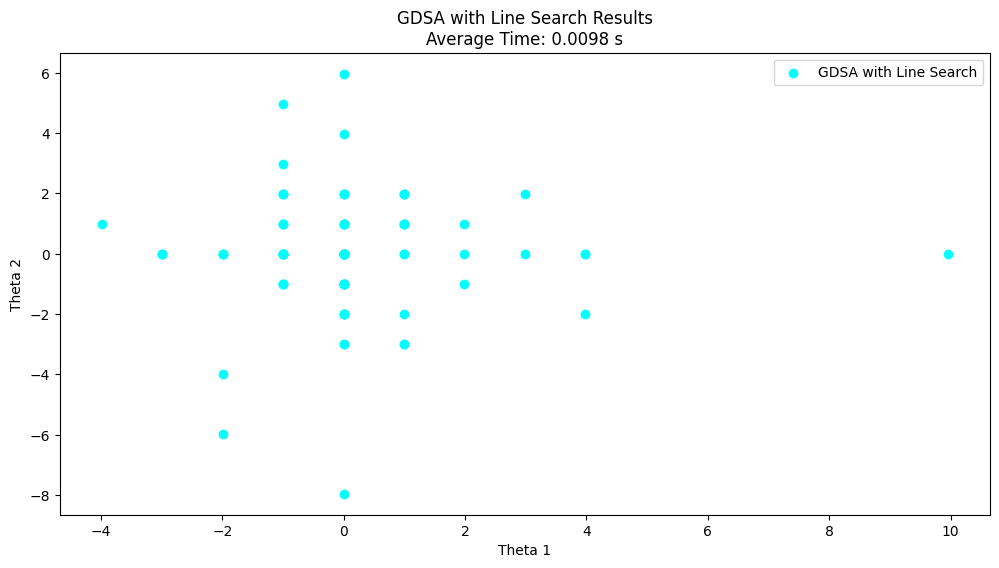

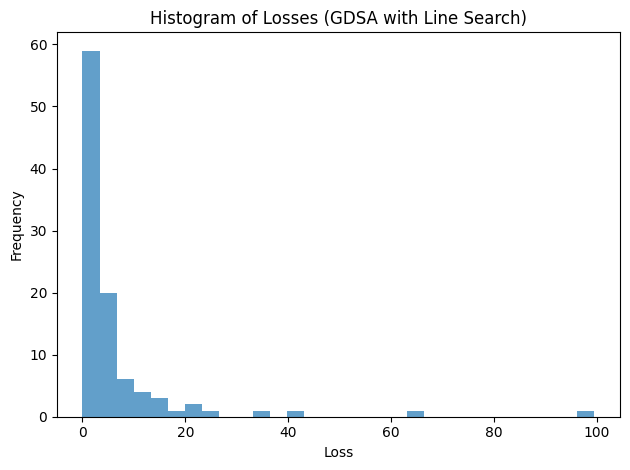

In [87]:

num_trials = 100
final_theta_linesearch = np.zeros((num_trials, 2))
times_linesearch = []

for i in range(num_trials):
    init_theta = np.random.uniform(-10, 10, 2)
    start_time = time.time()
    final_theta_linesearch[i], _ = gdsa_linesearch2(rastrigin_function, rastrigin_gradient, init_theta.copy(), **best_params)
    times_linesearch.append(time.time() - start_time)

avg_time_linesearch = np.mean(times_linesearch)
plt.figure(figsize=(12, 6))
plt.scatter(final_theta_linesearch[:, 0], final_theta_linesearch[:, 1], color='cyan', label='GDSA with Line Search')
plt.title(f'GDSA with Line Search Results\nAverage Time: {avg_time_linesearch:.4f} s')
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')
plt.legend()
plt.show()

loss_linesearch = np.array([rastrigin_function(theta) for theta in final_theta_linesearch])

plt.hist(loss_linesearch, bins=30, alpha=0.7)
plt.title('Histogram of Losses (GDSA with Line Search)')
plt.xlabel('Loss')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [88]:


# Modified gradient descent with line search
def gradient_descent_with_line_search(f, grad_f, init_theta, beta, max_iter, c=1e-4):
    theta = init_theta
    theta_updates = [theta.copy()]
    for i in range(max_iter):
        gradient = grad_f(theta)
        # Use line search to determine the best step size
        alpha = line_search(f, gradient, theta, -gradient, alpha=1.0, beta=beta, c=c)
        theta -= alpha * gradient
        theta_updates.append(theta.copy())
        if np.linalg.norm(alpha * gradient) < 1e-6:
            break
    return theta, theta_updates

final_theta_gd_ls, updates_gd_ls = gradient_descent_with_line_search(rastrigin_function, rastrigin_gradient, init_theta, 0.5, max_iter)

# Calculate the final results loss
loss_gd_ls = rastrigin_function(final_theta_gd_ls)

final_theta_gd_ls, loss_gd_ls


(array([3.97978363, 2.98485587]), 24.87384503396479)

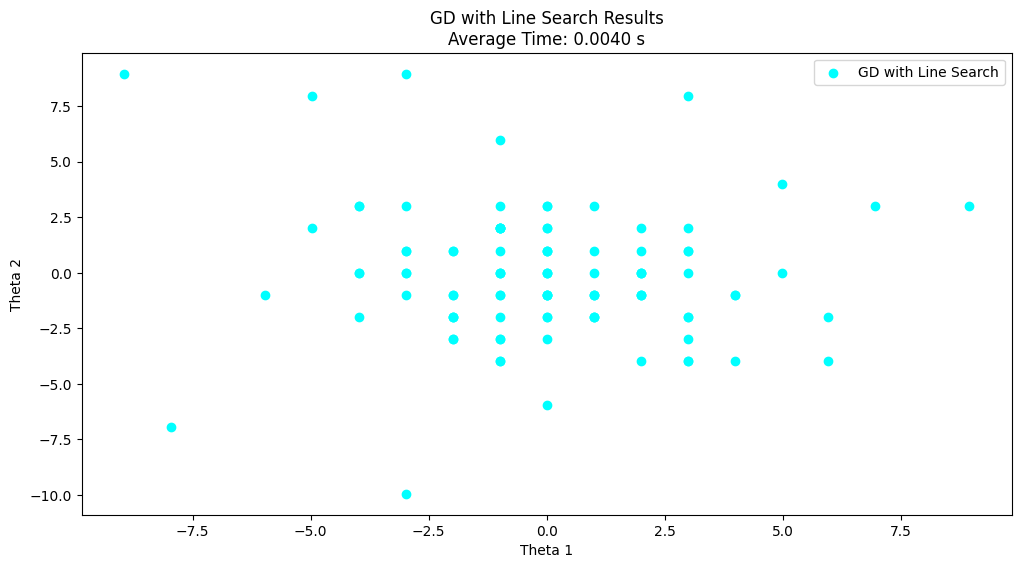

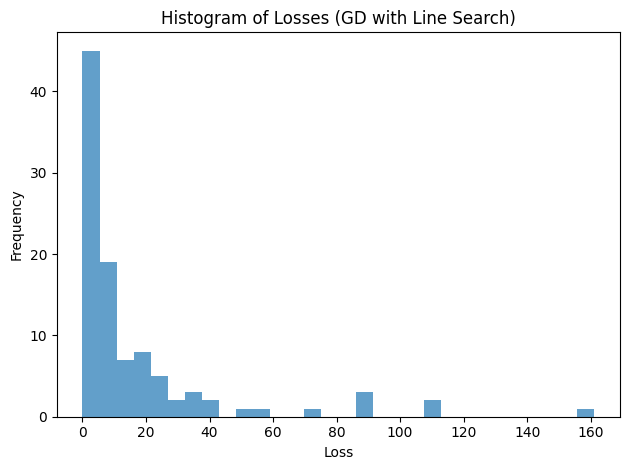

In [89]:
gd_ls_params = {
    'beta': 0.5,
    'max_iter': max_iter,
    'c': 1e-4
}
num_trials = 100
final_theta_gd_ls = np.zeros((num_trials, 2))
times_gdlinesearch = []

for i in range(num_trials):
    init_theta = np.random.uniform(-10, 10, 2)
    start_time = time.time()
    final_theta_gd_ls[i], _ = gradient_descent_with_line_search(rastrigin_function, rastrigin_gradient, init_theta.copy(), **gd_ls_params)
    times_gdlinesearch.append(time.time() - start_time)

avg_time_gdlinesearch = np.mean(times_gdlinesearch)
plt.figure(figsize=(12, 6))
plt.scatter(final_theta_gd_ls[:, 0], final_theta_gd_ls[:, 1], color='cyan', label='GD with Line Search')
plt.title(f'GD with Line Search Results\nAverage Time: {avg_time_gdlinesearch:.4f} s')
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')
plt.legend()
plt.show()


loss_linesearch = np.array([rastrigin_function(theta) for theta in final_theta_gd_ls])

plt.hist(loss_linesearch, bins=30, alpha=0.7)
plt.title('Histogram of Losses (GD with Line Search)')
plt.xlabel('Loss')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
